In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load your dataset
data = pd.read_csv('prf_I5_2000_9_norm_landsat8.csv')

# Preprocessing steps
data.ffill(inplace=True)  # Forward fill for handling missing values
data = pd.get_dummies(data)  # Convert categorical variables to dummy/indicator variables

# Split the data into training and validation sets
train_val_data, test_data = train_test_split(data, test_size=0.1, random_state=42)


In [8]:
# Check the columns in the DataFrame to ensure 'target_column' exists
print(train_val_data.columns)

# Initialize the feature selector with the f_classif function and a suitable k value
selector = SelectKBest(score_func=f_classif, k=10)

# Ensure 'target_column' exists before attempting to drop it
if 'target_column' in train_val_data.columns:
    # Fit and transform the training data
    X_train_selected = selector.fit_transform(train_val_data.drop('target_column', axis=1), train_val_data['target_column'])
else:
    print("Error: 'target_column' not found in the DataFrame.")

Index(['area', 'age', 'site_index', 'band1_mean', 'band2_mean', 'band3_mean',
       'band4_mean', 'band5_mean', 'band7_mean', 'Target'],
      dtype='object')
Error: 'target_column' not found in the DataFrame.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from xgboost import XGBRegressor


In [10]:
# Load dataset
data = pd.read_csv('tvol_lidarLiveP.csv')

# Print column names to see available columns
print("Available columns:", list(data.columns))

# Define features and target
# Replace 'actual_target_column_name' with the correct column name from your dataset
target_column = 'Target'  # modify this line with your actual target column name
X = data.drop(target_column, axis=1)
y = data[target_column]

# Split data into training and validation (90% train, 10% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

Available columns: ['Status', 'origin', 'zmax', 'zmean', 'zsd', 'zskew', 'zkurt', 'pzabovezmean', 'pzabove2', 'zq5', 'zq10', 'zq15', 'zq20', 'zq25', 'zq30', 'zq35', 'zq40', 'zq45', 'zq50', 'zq55', 'zq60', 'zq65', 'zq70', 'zq75', 'zq80', 'zq85', 'zq90', 'zq95', 'zpcum1', 'zpcum2', 'zpcum3', 'zpcum4', 'zpcum5', 'zpcum6', 'zpcum7', 'zpcum8', 'zpcum9', 'Target']


In [12]:
# Models to evaluate
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(),
    'XGBoost': XGBRegressor()
}

# Function to evaluate models
def evaluate_model(model, X, y, name):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X, y, cv=kfold, scoring='r2')
    model.fit(X, y)
    y_pred = model.predict(X)
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    print(f"{name} - MAE: {mae}, MSE: {mse}, R2-Score: {r2}")
    
    # Save model and metrics
    with open(f'{name}_Baseline.pkl', 'wb') as file:
        pickle.dump(model, file)
    
    return mae, mse, r2

# Evaluate each model
results = {}
for name, model in models.items():
    results[name] = evaluate_model(model, X_train, y_train, name)


LinearRegression - MAE: 57.14074194409077, MSE: 5906.6569810718, R2-Score: 0.8001084057496105
RandomForest - MAE: 22.529388103405797, MSE: 1028.20205988672, R2-Score: 0.965203845488079
XGBoost - MAE: 0.0017618643463130654, MSE: 6.6657112882547814e-06, R2-Score: 0.9999999997744207


In [14]:
def feature_selection_and_evaluation(model, X, y, name_prefix):
    selector = RFE(model, n_features_to_select=5)  # Adjust n_features accordingly
    selector.fit(X, y)
    features = X.columns[selector.support_]
    
    # Save selected features to JSON
    with open(f'Features_{name_prefix}.json', 'w') as file:
        json.dump(features.tolist(), file)
    
    # Evaluate model with selected features
    mae, mse, r2 = evaluate_model(model, X[features], y, name_prefix)
    return mae, mse, r2, features

# Perform feature selection and evaluation for RF and XGB with RFE
for name in ['RandomForest', 'XGBoost']:
    feature_selection_and_evaluation(models[name], X_train, y_train, f'RFE_{name}')


RFE_RandomForest - MAE: 24.091928532597287, MSE: 1041.0069762487667, R2-Score: 0.9647705047415189
RFE_XGBoost - MAE: 1.2724887865292411, MSE: 3.1182266537033527, R2-Score: 0.9998944737608702


66.81532170970394


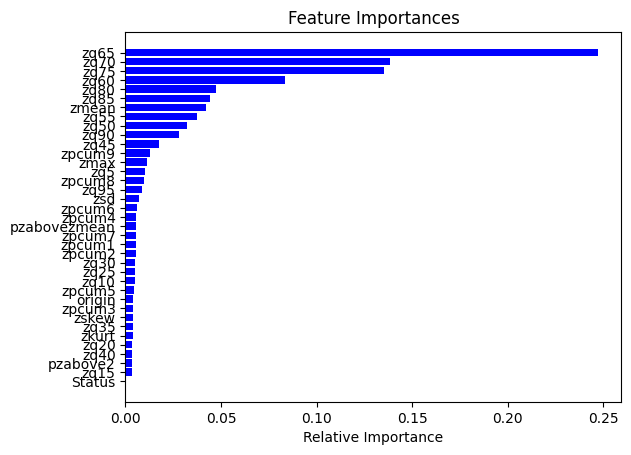

In [16]:
# Load results for analysis (if needed from disk)
with open('RandomForest_Baseline.pkl', 'rb') as file:
    rf_model = pickle.load(file)

# Use the loaded model for further predictions or analysis
y_pred = rf_model.predict(X_test)
print(mean_absolute_error(y_test, y_pred))

# Visualization of feature importances (for RF as an example)
importances = rf_model.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()
